<a href="https://colab.research.google.com/github/AaronGonzalezB/monografia-especializacion-udea/blob/main/IEEE_CIS_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IEEE-CIS Fraud Detection

Link competición: https://www.kaggle.com/c/ieee-fraud-detection/

Detección de transacciones fraudulentas en un sitio de E-commerce, para mejorar el sistema de alertas de transacciones irregulares que maneja la empresa de seguridad Vesta.

El dataset se constituye por 393 features y 5.9 millones de registros para un problema de clasificación binaria cuyo se desempeño para la competencia se medirá a través de la curva ROC. Se explorarán métricas adicionales que permitan brindar más información.

####Dataset

1. Tabla transaccional
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp) - type: number of seconds.
* TransactionAMT: transaction payment amount in USD
* ProductCD (Categorical): product code, the product for each transaction
* card1 - card6 (Categorical): payment card information, such as card type, card category, issue bank, country, etc.
* addr (Categorical): address
* dist: distance
* P_ and (R__) emaildomain (Categorical): purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9 (Categorical): match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

2. Tabla de identidad (información sesión - usuario)

* DeviceType: Tipo de dispositivo con el que se ingresó.
* DeviceInfo: Información del dispositivo 
* id_12 - id_38: features enmascarados correspondientes al detalle de la sesión abierta y el usuario que ingresó



## Conexión con Kaggle para descarga de información

Tomado de: https://www.kaggle.com/general/74235

1. Instalamos Kaggle en el notebook

In [1]:
cd /content

/content


In [2]:
! rm kaggle.json   #Descomentar en caso de actualizar archivo

In [3]:
! rm -rf monografia

In [4]:
! rm -rf dataset

In [5]:
! pip install joblib

In [6]:
!pip install ipython-autotime

%load_ext autotime

time: 182 µs (started: 2021-06-07 23:53:47 +00:00)


In [7]:
! pip install -q kaggle

time: 3.13 s (started: 2021-06-07 23:53:47 +00:00)


2. Generamos en el perfil de Kaggle un Token, este se guardará en el directorio del usuario: 

        C:\Users\user\.kaggle

Cargamos el json que está en el directorio.

In [8]:
from google.colab import files

files.upload()   #Descomentar en caso de actualizar archivo

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aargonzalezbe","key":"5cba41f880921ea15aad85dbdf410683"}'}

time: 9.47 s (started: 2021-06-07 23:53:51 +00:00)


3. Creamos el directorio donde almacenaremos el json en Colab

In [9]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
time: 134 ms (started: 2021-06-07 23:54:00 +00:00)


4. Copiamos el json y lo agregamos al directorio

In [10]:
! cp kaggle.json ~/.kaggle/

time: 118 ms (started: 2021-06-07 23:54:00 +00:00)


4. Establecemos permisos de lectura y escritura sobre el archivo.

  https://chmodcommand.com/chmod-600/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

time: 133 ms (started: 2021-06-07 23:54:00 +00:00)


5. Chequeamos que hallamos accedido a la API de Kaggle correctamente

In [12]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6965  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4176  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1389  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2156  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

## Descarga del dataset del proyecto

Creamos el directorio y descargamos el dataset. Se debe descomprimir la información

In [13]:
! mkdir monografia

time: 119 ms (started: 2021-06-07 23:54:02 +00:00)


In [14]:
cd monografia/

/content/monografia
time: 7.76 ms (started: 2021-06-07 23:54:02 +00:00)


In [15]:
! mkdir dataset

time: 122 ms (started: 2021-06-07 23:54:02 +00:00)


In [16]:
cd dataset/

/content/monografia/dataset
time: 2.38 ms (started: 2021-06-07 23:54:02 +00:00)


In [17]:
! kaggle competitions download -c ieee-fraud-detection

 86% 45.0M/52.2M [00:00<00:00, 46.2MB/s]
100% 52.2M/52.2M [00:00<00:00, 82.3MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 75.1MB/s]
 89% 52.0M/58.3M [00:00<00:00, 64.8MB/s]
100% 58.3M/58.3M [00:00<00:00, 85.3MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 107MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 96.8MB/s]
time: 3.75 s (started: 2021-06-07 23:54:02 +00:00)


In [18]:
from joblib import parallel_backend
import os
import sys
import zipfile
from google.colab import files
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import seaborn as sn 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import plot_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, make_scorer, roc_auc_score, precision_score, recall_score,average_precision_score,f1_score,matthews_corrcoef

import pickle

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows",None)
np.set_printoptions(threshold=sys.maxsize)

time: 1.67 s (started: 2021-06-07 23:54:06 +00:00)


In [19]:
# Descrompimimos los archivos
for dirname, _, filenames in os.walk('/content/monografia/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        with zipfile.ZipFile(os.path.join(dirname, filename),"r") as zip_ref:
            zip_ref.extractall(dirname)

/content/monografia/dataset/sample_submission.csv.zip
/content/monografia/dataset/test_identity.csv.zip
/content/monografia/dataset/train_identity.csv.zip
/content/monografia/dataset/train_transaction.csv.zip
/content/monografia/dataset/test_transaction.csv.zip
time: 8.07 s (started: 2021-06-07 23:54:07 +00:00)


## Lectura del dataset

In [20]:
filenames = ['sample_submission.csv','test_identity.csv','test_transaction.csv','train_identity.csv','train_transaction.csv']
dataframes = []

for f in filenames:
    dataframes.append(pd.read_csv(f))
    print("Lectura del dataset: {}".format(f))

Lectura del dataset: sample_submission.csv
Lectura del dataset: test_identity.csv
Lectura del dataset: test_transaction.csv
Lectura del dataset: train_identity.csv
Lectura del dataset: train_transaction.csv
time: 49.5 s (started: 2021-06-07 23:54:15 +00:00)


In [21]:
# Asignamos los dataset correspondientes
sample_submission, X_test_id, X_test_tr, X_train_id, X_train_tr = dataframes

time: 1.73 ms (started: 2021-06-07 23:55:05 +00:00)


Dada la capacidad limitada de Colab para tratar estos datasets de forma local, se tratará de reducir el uso de memoria de los datasets cargados casteándolos al tipo de dato más eficiente para cada feature - https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

In [22]:
# Función de casteo
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

time: 69.2 ms (started: 2021-06-07 23:55:05 +00:00)


In [23]:
# Casteo de los datasets
X_train_id, NAList = reduce_mem_usage(X_train_id)

Memory usage of properties dataframe is : 45.11695098876953  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  id_01
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_02
dtype before:  float64
dtype after:  uint32
******************************
******************************
Column:  id_03
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_04
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_05
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_06
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_07
dtype before:  float64
dtype after:  int8
*****

In [24]:
X_train_tr, NAList = reduce_mem_usage(X_train_tr)

Memory usage of properties dataframe is : 1775.1524047851562  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  isFraud
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
d

In [25]:
X_test_id, NAList = reduce_mem_usage(X_test_id)

Memory usage of properties dataframe is : 44.389366149902344  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  id-01
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id-02
dtype before:  float64
dtype after:  uint32
******************************
******************************
Column:  id-03
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id-04
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id-05
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id-06
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id-07
dtype before:  float64
dtype after:  int8
****

In [26]:
X_test_tr, NAList = reduce_mem_usage(X_test_tr)

Memory usage of properties dataframe is : 1519.2381210327148  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionDT
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  card5
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  addr1
dtype before:  float64
d

In [27]:
# Consumo de memoria de los datasets optimizados en tipo de datos
print('Memoria usada para dataset de entrenamiento de Identidad en MB:', X_train_id.memory_usage().sum() / 1024**2) 
print('Memoria usada para dataset de entrenamiento Transaccionales en MB:', X_train_tr.memory_usage().sum() / 1024**2) 

print('Memoria usada para dataset de validacion de Identidad en MB:', X_test_id.memory_usage().sum() / 1024**2)
print('Memoria usada para dataset de validación Transaccionales en MB:', X_test_tr.memory_usage().sum() / 1024**2) 

Memoria usada para dataset de entrenamiento de Identidad en MB: 23.934049606323242
Memoria usada para dataset de entrenamiento Transaccionales en MB: 450.54638671875
Memoria usada para dataset de validacion de Identidad en MB: 23.54807472229004
Memoria usada para dataset de validación Transaccionales en MB: 376.9103126525879
time: 22.6 ms (started: 2021-06-07 23:57:58 +00:00)


Con la implementación de la función de casteo pasamos a tener un consumo de 4.7GB aproximadamente a 0.99 GB

##Analisis exploratorio

### Unificación de tablas ID y TRX

Como el dataset posee dos tablas (transactions, ID) las juntaremos para tener un solo dataset para train y uno solo para test

In [28]:
X_train_tr.shape, X_train_id.shape

((590540, 394), (144233, 41))

time: 4.51 ms (started: 2021-06-07 23:57:58 +00:00)


In [29]:
X_train = pd.merge(X_train_tr, X_train_id, how='left', on='TransactionID', left_index=True, right_index=True)
print(X_train.shape)

(590540, 434)
time: 978 ms (started: 2021-06-07 23:57:58 +00:00)


In [30]:
X_test_tr.shape, X_test_id.shape

((506691, 393), (141907, 41))

time: 6.41 ms (started: 2021-06-07 23:57:59 +00:00)


In [31]:
X_test = pd.merge(X_test_tr, X_test_id, how='left', on='TransactionID', left_index=True, right_index=True)
print(X_test.shape)

(506691, 433)
time: 814 ms (started: 2021-06-07 23:57:59 +00:00)


In [32]:
# Renombramos columnas a un formato válido para lectura
X_test = X_test.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})

time: 190 ms (started: 2021-06-07 23:58:00 +00:00)


In [33]:
# Para evitar crashes por memoria, cuando se vayan transformando datasets se depura del storage los datos que no se utilicen
del X_train_tr, X_train_id, X_test_tr, X_test_id; x = gc.collect()

time: 73 ms (started: 2021-06-07 23:58:00 +00:00)


En los datos de entrenamiento, la media de transacciones fraudulentas es unicamente del 0.0349, es decir del 3.5% del total de las observaciones

Validando el % de trx fraudulentas:

Revisando las diferencias entre los datasets suministrados de test y train, se debe garantizar que el dataset de prueba no tenga la variable objetivo:

In [34]:
def differentcolumns(traincols, testcols):
    for i in traincols:
        if i not in testcols:
            print(i)

differentcolumns(X_train.columns, X_test.columns)

isFraud
time: 5.71 ms (started: 2021-06-07 23:58:00 +00:00)


Validando entre los datos de entrenamiento y test, se valida que la unica columna diferente es el **target**

### Imputación de valores nulos

* Se eliminan los features que tengan más de un 80% de valores perdidos.

In [35]:
def features(data):

  features = data.isnull().sum().sort_values(ascending=False)
  percent = data.isnull().sum() / data.shape[0]

  null_features = pd.concat([features, percent], axis=1, keys = ['Features', 'Percent'])

  return null_features

# Se retorna el # de observaciones nulas y su % respecto al total
null_features_x = features(X_train)

time: 2.39 s (started: 2021-06-07 23:58:00 +00:00)


Se implementa un límite máximo de nulos en cada feature, que debe ser inferior al 20% del dataset

Si no se cumple la condición se elimina el feature.

In [36]:
limit = 0.2

x_columns_filter = null_features_x[null_features_x['Percent'] > limit].index

time: 2.91 ms (started: 2021-06-07 23:58:03 +00:00)


In [37]:
print("# de variables con más de 80% de valores perdidos: {}".format(x_columns_filter.shape[0]))

# de variables con más de 80% de valores perdidos: 50
time: 2.56 ms (started: 2021-06-07 23:58:03 +00:00)


In [38]:
# Se eliminan las columnas del dataset de entrenamiento y de validación

X_train.drop(x_columns_filter, axis=1, inplace=True)
X_test.drop(x_columns_filter, axis=1, inplace=True)

time: 1.43 s (started: 2021-06-07 23:58:03 +00:00)


In [39]:
X_train.shape, X_test.shape

((590540, 384), (506691, 383))

time: 6.76 ms (started: 2021-06-07 23:58:04 +00:00)


In [40]:
null_features_x_train = features(X_train)
null_features_x_test = features(X_test)

time: 1.95 s (started: 2021-06-07 23:58:04 +00:00)


Depuramos los nulos restantes, analizando su impacto variable por variable:

* **card4**:

In [41]:
# card4
X_train['card4'].fillna('NA', inplace = True)
X_test['card4'].fillna('NA', inplace = True)

time: 53.6 ms (started: 2021-06-07 23:58:06 +00:00)


Con esta validacion, se tienen 41 trx fraudulentas cuya franquicia no fue identificada, por ende se creará una categoria de "NA" para estas trx.

* **card6**:

In [42]:
# card6
X_train['card6'].fillna('NA', inplace = True)
X_test['card6'].fillna('NA', inplace = True)

time: 55 ms (started: 2021-06-07 23:58:06 +00:00)


Con esta validacion, se tienen 39 trx fraudulentas cuyo tipo de tarjeta no fue identificado, por ende se creará una categoria de "NA" para estas trx.

* **P_emaildomain**:

In [43]:
# P_emaildomain
X_train['P_emaildomain'].fillna('NA', inplace = True)
X_test['P_emaildomain'].fillna('NA', inplace = True)

time: 59.8 ms (started: 2021-06-07 23:58:06 +00:00)


Con esta validacion, se tienen 2790 trx fraudulentas cuyo dominio de mail no fue identificado, por ende se creará una categoria de "NA" para estas trx. Esta vez si se encontró una mayor proporción de trx sin dominio registrado marcado como movimientos irregulares.

Creamos nuevas categorias a partir de los nulos residuales, dado que solo quedaron en variables de este tipo

In [44]:
X_train.shape, X_test.shape

((590540, 384), (506691, 383))

time: 6.34 ms (started: 2021-06-07 23:58:06 +00:00)


Ya el dataset está limpio de valores perdidos

### Variables categóricas

#### Descriptivos

Podemos determinar la incidencia de ciertas variables en caso de que se relacionen con el target:

* ProductCD
* card1 - card6
* addr1: Billing region
* addr2: Billing country
* P_emaildomain
* R_emaildomain (depurada por nulos)
* M1 - M9 (depurados por nulos)

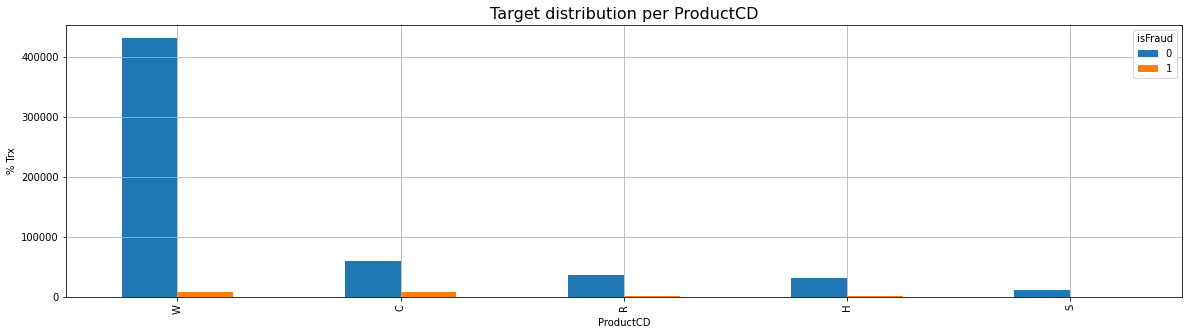


Volume distribution per ProductCD:
        ProductCD   count       percent            Total
isFraud                 0     1       0      1          
4               W  430701  8969   97.96   2.04  439670.0
0               C   60511  8008   88.31  11.69   68519.0
1               H   31450  1574   95.23   4.77   33024.0
2               R   36273  1426   96.22   3.78   37699.0
3               S   10942   686   94.10   5.90   11628.0
time: 448 ms (started: 2021-06-07 23:58:06 +00:00)


In [45]:
# Por volumen
product_cd = X_train.groupby(["ProductCD", "isFraud"]).size().to_frame(name = 'count').reset_index()
count_tb = product_cd[["ProductCD","count"]].groupby(["ProductCD"]).sum().reset_index()

product_merge_percent = pd.merge(product_cd, count_tb, how='left', on='ProductCD', left_index=True, right_index=False)
product_merge_percent['percent'] = round((product_merge_percent['count_x']/product_merge_percent['count_y'])*100,2)
product_merge_percent.columns = ['ProductCD', 'isFraud', 'count', 'total', 'percent']

product_cd_p = pd.pivot_table(product_merge_percent, index = 'ProductCD', columns = 'isFraud', values = 'count')
product_cd_p['Total'] = product_cd_p.sum(axis=1)

product_cd_p_sort = product_cd_p.sort_values(by = ["Total"], ascending=False)
product_cd_p_sort.iloc[:,:-1].plot(kind = 'bar', figsize = (20,5), grid = True)

plt.title('Target distribution per ProductCD'.format(5), fontsize = 16)
plt.ylabel("% Trx")
plt.show()

print_feature_graph_p = pd.pivot_table(product_merge_percent, index = "ProductCD", columns = "isFraud", values = ['count','percent']).reset_index()
print_feature_graph_p['Total'] = print_feature_graph_p.sum(axis=1) - 100
print_feature_graph_p = print_feature_graph_p.sort_values(by = ('count',1), ascending=False).head(10)

print("\nVolume distribution per {}:".format("ProductCD"))
print(print_feature_graph_p)

Dado el volumen de datos y el desbalanceo que existe en estos, graficar valores absolutos no representa graficamente una visualización clara de cada feature, por tanto los detallaremos a nivel de %

In [46]:
# Funcion para graficar las distribuciones por feature del target
def percent_bar_graph(data, variables,top):

  plt.rcParams.update({'font.size': 26})

  TOP = top

  feature_graph = data.groupby(variables).size().to_frame(name = 'count').reset_index()

  count_tb = feature_graph[[variables[0],'count']].groupby(variables[0]).sum().reset_index()

  merge_percent = pd.merge(feature_graph, count_tb, how='left', on=variables[0], left_index=True, right_index=False)
  merge_percent['percent'] = round((merge_percent['count_x']/merge_percent['count_y'])*100,2)
  merge_percent.columns = [variables[0], variables[1], 'count', 'total', 'percent']

  feature_graph_p = pd.pivot_table(merge_percent, index = variables[0], columns = variables[1], values = 'percent')
  feature_graph_p['Total'] = feature_graph_p.sum(axis=1)

  feature_graph_p_sort = feature_graph_p.sort_values(by = [1], ascending=False).head(TOP)
  feature_graph_p_sort.iloc[:,:-1].plot(kind = 'bar', figsize = (20,5), grid = True)

  plt.title('Target distribution per {} in %'.format(variables[0]), fontsize = 22)
  plt.ylabel("% Trx")
  plt.show()

  feature_vol = data.groupby(variables).size().to_frame(name = 'count').reset_index()
  feature_vol_p = pd.pivot_table(feature_vol, index = variables[0], columns = variables[1], values = 'count')
  feature_vol_p['Total'] = feature_vol_p.sum(axis=1)

  #print_merge_percent = merge_percent.sort_values(by = ['total'], ascending=False).head(TOP)

  print_feature_graph_p = pd.pivot_table(merge_percent, index = variables[0], columns = variables[1], values = ['count','percent'])
  print_feature_graph_p['Total'] = print_feature_graph_p.sum(axis=1) - 100
  print_feature_graph_p = print_feature_graph_p.sort_values(by = ('percent',1), ascending=False).head(TOP)

  print("\nTarget distribution per {} in Volume:".format(variables[0]))
  print(print_feature_graph_p)

time: 39.5 ms (started: 2021-06-07 23:58:07 +00:00)


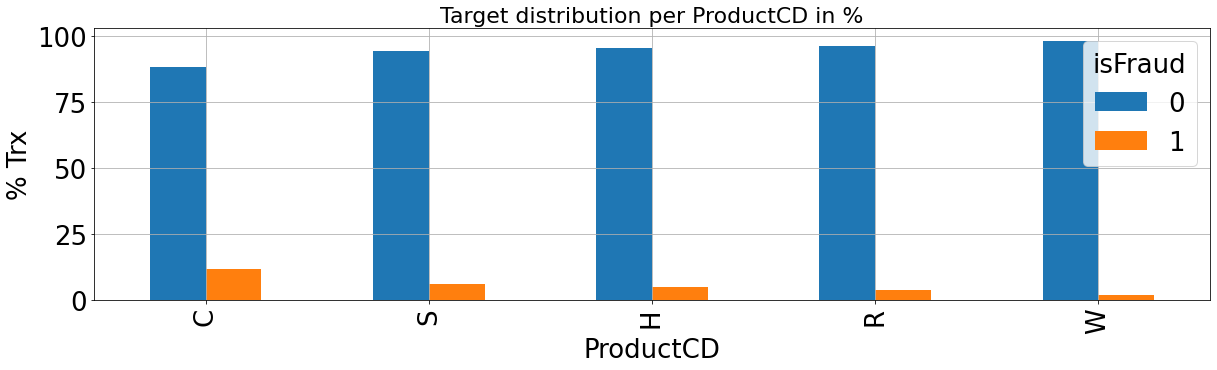


Target distribution per ProductCD in Volume:
            count       percent            Total
isFraud         0     1       0      1          
ProductCD                                       
C           60511  8008   88.31  11.69   68519.0
S           10942   686   94.10   5.90   11628.0
H           31450  1574   95.23   4.77   33024.0
R           36273  1426   96.22   3.78   37699.0
W          430701  8969   97.96   2.04  439670.0
time: 499 ms (started: 2021-06-07 23:58:07 +00:00)


In [47]:
# ProductCD
list_var = ["ProductCD", "isFraud"]
top = len(X_train[list_var[0]].unique())
percent_bar_graph(X_train, list_var, top)

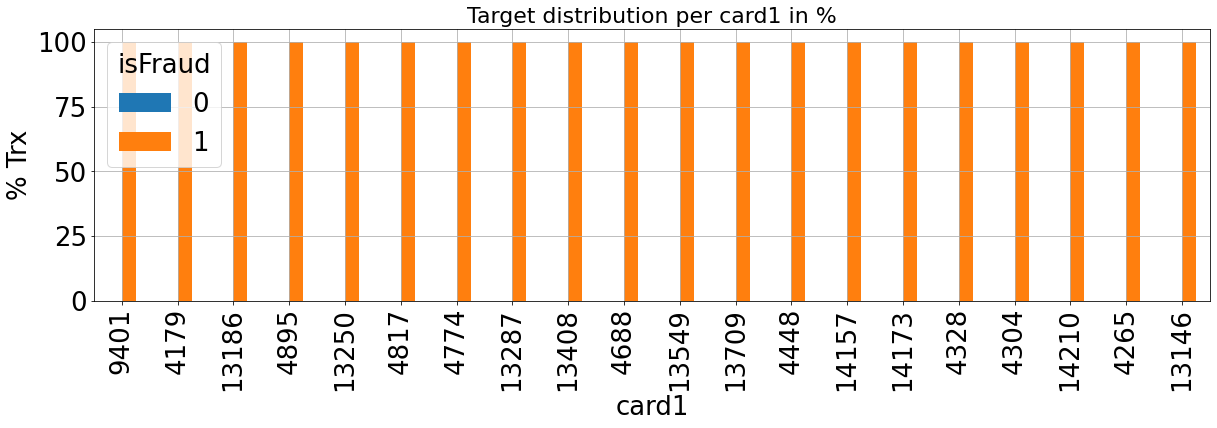


Target distribution per card1 in Volume:
        count      percent        Total
isFraud     0    1       0      1      
card1                                  
9401      NaN  3.0     NaN  100.0   3.0
4179      NaN  5.0     NaN  100.0   5.0
13186     NaN  1.0     NaN  100.0   1.0
4895      NaN  1.0     NaN  100.0   1.0
13250     NaN  1.0     NaN  100.0   1.0
4817      NaN  1.0     NaN  100.0   1.0
4774      NaN  6.0     NaN  100.0   6.0
13287     NaN  2.0     NaN  100.0   2.0
13408     NaN  1.0     NaN  100.0   1.0
4688      NaN  1.0     NaN  100.0   1.0
13549     NaN  4.0     NaN  100.0   4.0
13709     NaN  1.0     NaN  100.0   1.0
4448      NaN  5.0     NaN  100.0   5.0
14157     NaN  4.0     NaN  100.0   4.0
14173     NaN  1.0     NaN  100.0   1.0
4328      NaN  1.0     NaN  100.0   1.0
4304      NaN  2.0     NaN  100.0   2.0
14210     NaN  1.0     NaN  100.0   1.0
4265      NaN  1.0     NaN  100.0   1.0
13146     NaN  1.0     NaN  100.0   1.0


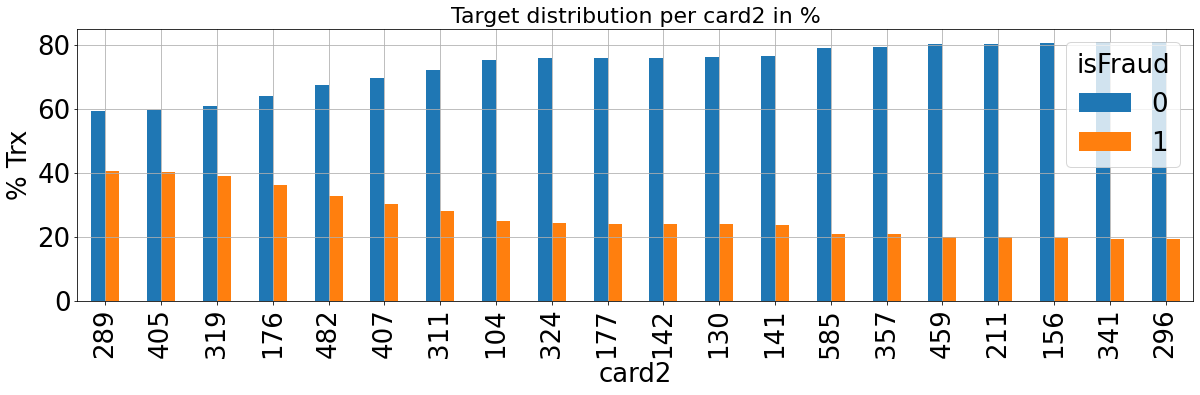


Target distribution per card2 in Volume:
          count        percent          Total
isFraud       0      1       0      1        
card2                                        
289        70.0   48.0   59.32  40.68   118.0
405       136.0   92.0   59.65  40.35   228.0
319        61.0   39.0   61.00  39.00   100.0
176       328.0  185.0   63.94  36.06   513.0
482       113.0   55.0   67.26  32.74   168.0
407        39.0   17.0   69.64  30.36    56.0
311       208.0   81.0   71.97  28.03   289.0
104       567.0  187.0   75.20  24.80   754.0
324       251.0   80.0   75.83  24.17   331.0
177      1246.0  396.0   75.88  24.12  1642.0
142      1280.0  405.0   75.96  24.04  1685.0
130      2089.0  657.0   76.07  23.93  2746.0
141       213.0   66.0   76.34  23.66   279.0
585       312.0   83.0   78.99  21.01   395.0
357        76.0   20.0   79.17  20.83    96.0
459       542.0  135.0   80.06  19.94   677.0
211        81.0   20.0   80.20  19.80   101.0
156        82.0   20.0   80.39  19.61 

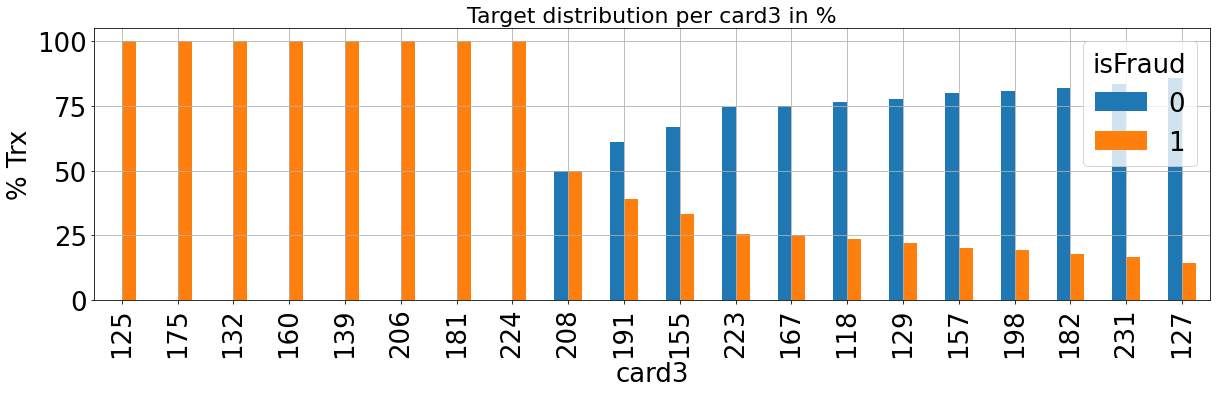


Target distribution per card3 in Volume:
        count       percent         Total
isFraud     0     1       0       1      
card3                                    
125       NaN   1.0     NaN  100.00   1.0
175       NaN   1.0     NaN  100.00   1.0
132       NaN   1.0     NaN  100.00   1.0
160       NaN   3.0     NaN  100.00   3.0
139       NaN   1.0     NaN  100.00   1.0
206       NaN   2.0     NaN  100.00   2.0
181       NaN   3.0     NaN  100.00   3.0
224       NaN   1.0     NaN  100.00   1.0
208       1.0   1.0   50.00   50.00   2.0
191      11.0   7.0   61.11   38.89  18.0
155       2.0   1.0   66.67   33.33   3.0
223      41.0  14.0   74.55   25.45  55.0
167       3.0   1.0   75.00   25.00   4.0
118      13.0   4.0   76.47   23.53  17.0
129       7.0   2.0   77.78   22.22   9.0
157       4.0   1.0   80.00   20.00   5.0
198      25.0   6.0   80.65   19.35  31.0
182      32.0   7.0   82.05   17.95  39.0
231       5.0   1.0   83.33   16.67   6.0
127      24.0   4.0   85.71   14.2

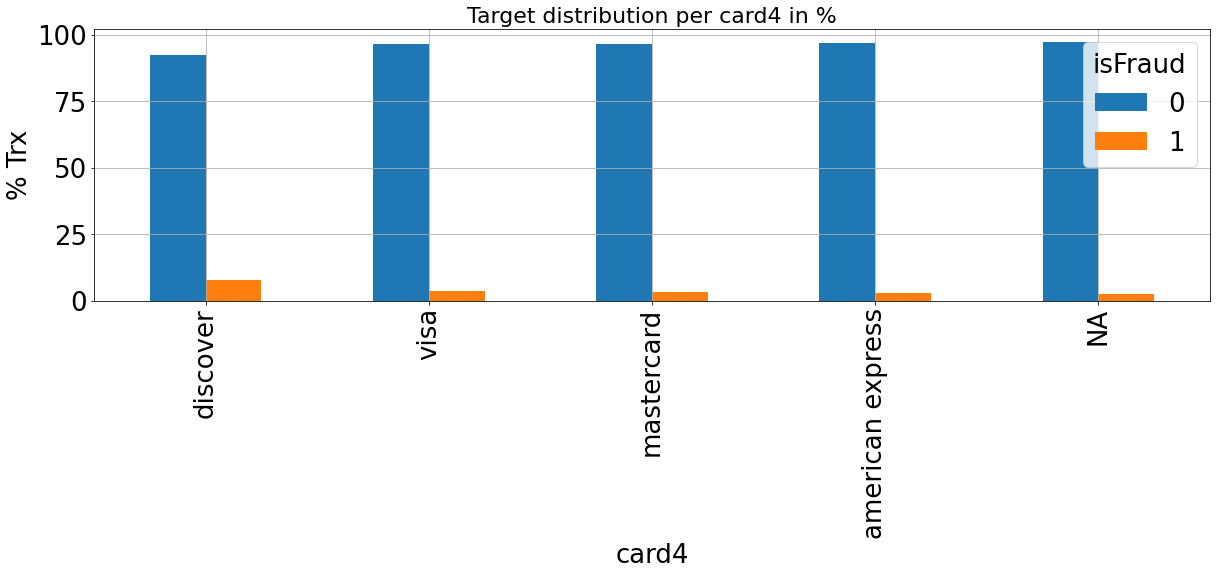


Target distribution per card4 in Volume:
                   count        percent           Total
isFraud                0      1       0     1          
card4                                                  
discover            6137    514   92.27  7.73    6651.0
visa              371394  13373   96.52  3.48  384767.0
mastercard        182721   6496   96.57  3.43  189217.0
american express    8089    239   97.13  2.87    8328.0
NA                  1536     41   97.40  2.60    1577.0


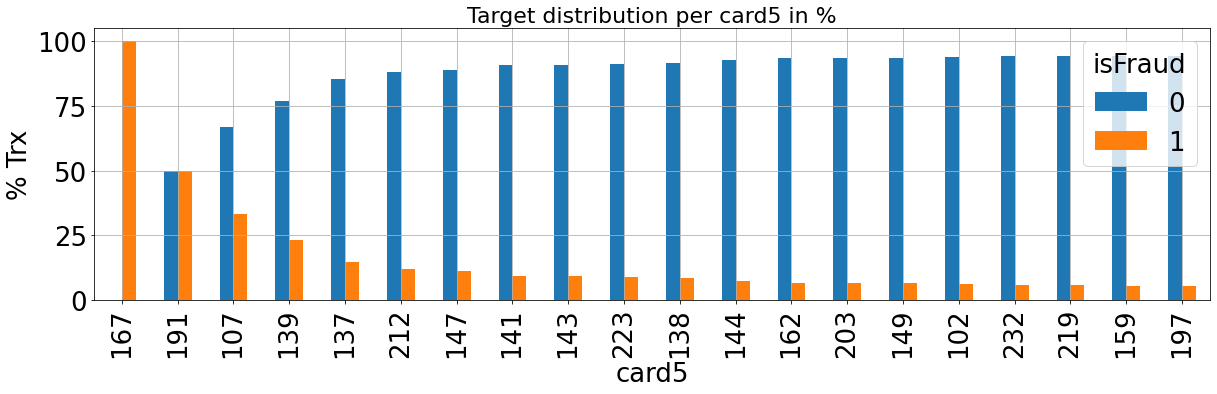


Target distribution per card5 in Volume:
           count         percent            Total
isFraud        0       1       0       1         
card5                                            
167          NaN     1.0     NaN  100.00      1.0
191          1.0     1.0   50.00   50.00      2.0
107          8.0     4.0   66.67   33.33     12.0
139         10.0     3.0   76.92   23.08     13.0
137       9995.0  1725.0   85.28   14.72  11720.0
212         37.0     5.0   88.10   11.90     42.0
147        370.0    47.0   88.73   11.27    417.0
141        309.0    32.0   90.62    9.38    341.0
143         39.0     4.0   90.70    9.30     43.0
223        853.0    83.0   91.13    8.87    936.0
138      18055.0  1682.0   91.48    8.52  19737.0
144        203.0    16.0   92.69    7.31    219.0
162       4223.0   301.0   93.35    6.65   4524.0
203        400.0    28.0   93.46    6.54    428.0
149         72.0     5.0   93.51    6.49     77.0
102      27273.0  1832.0   93.71    6.29  29105.0
232     

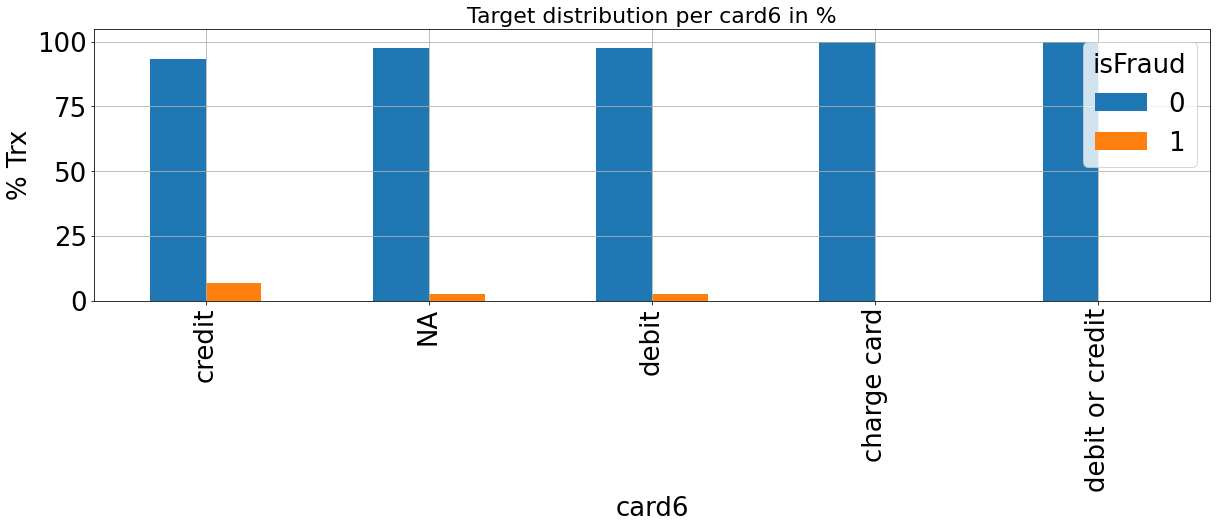


Target distribution per card6 in Volume:
                    count          percent           Total
isFraud                 0        1       0     1          
card6                                                     
credit           139036.0   9950.0   93.32  6.68  148986.0
NA                 1532.0     39.0   97.52  2.48    1571.0
debit            429264.0  10674.0   97.57  2.43  439938.0
charge card          15.0      NaN  100.00   NaN      15.0
debit or credit      30.0      NaN  100.00   NaN      30.0
time: 3.48 s (started: 2021-06-07 23:58:07 +00:00)


In [48]:
# card1 - card6

card1_card6 = ['card1','card2','card3','card4','card5','card6']
top = 20

for i in range(len(card1_card6)):
  list_var = [card1_card6[i], "isFraud"]
  percent_bar_graph(X_train, list_var, top)

Por la exploración se logró identificar dos variables: 

**"card4"** corresponde a la franquicia de Tarjeta de crédito usada en la transacción:

* American Express
* Discover (exclusiva en Estados Unidos)
* Mastercard
* Visa

**"card6"** corresponde al tipo de tarjeta con la que se realizó la transacción:

* Charge card: tipo especial de tdc, pagos completos mes a mes, sin limite de cupo, sin cobro de intereses.
* Credit
* Debit
* Debit or credit: no se tiene información suficiente para identificar el tipo exacto.



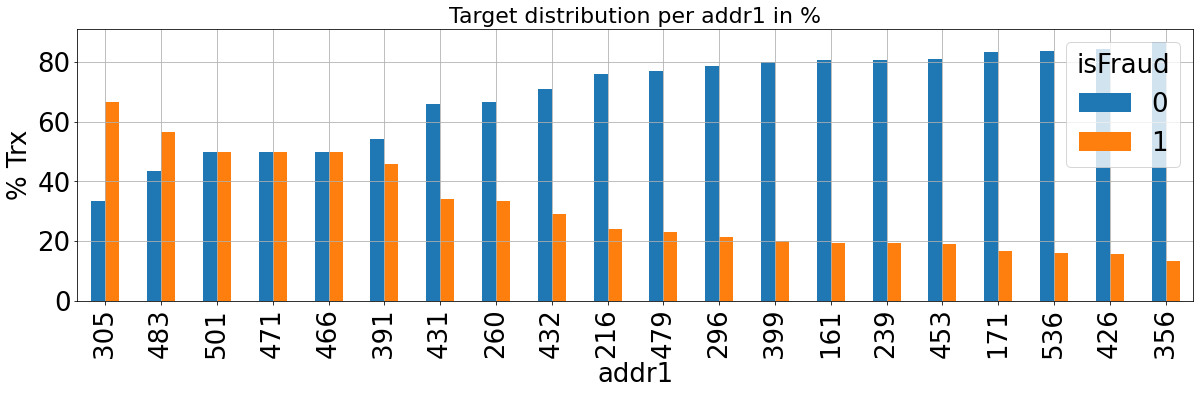


Target distribution per addr1 in Volume:
         count       percent         Total
isFraud      0     1       0      1       
addr1                                     
305        3.0   6.0   33.33  66.67    9.0
483       10.0  13.0   43.48  56.52   23.0
501        2.0   2.0   50.00  50.00    4.0
471        1.0   1.0   50.00  50.00    2.0
466        1.0   1.0   50.00  50.00    2.0
391       19.0  16.0   54.29  45.71   35.0
431       25.0  13.0   65.79  34.21   38.0
260        4.0   2.0   66.67  33.33    6.0
432       27.0  11.0   71.05  28.95   38.0
216       41.0  13.0   75.93  24.07   54.0
479       10.0   3.0   76.92  23.08   13.0
296      289.0  78.0   78.75  21.25  367.0
399        4.0   1.0   80.00  20.00    5.0
161      339.0  82.0   80.52  19.48  421.0
239       25.0   6.0   80.65  19.35   31.0
453       17.0   4.0   80.95  19.05   21.0
171       10.0   2.0   83.33  16.67   12.0
536      259.0  50.0   83.82  16.18  309.0
426       27.0   5.0   84.38  15.62   32.0
356       78

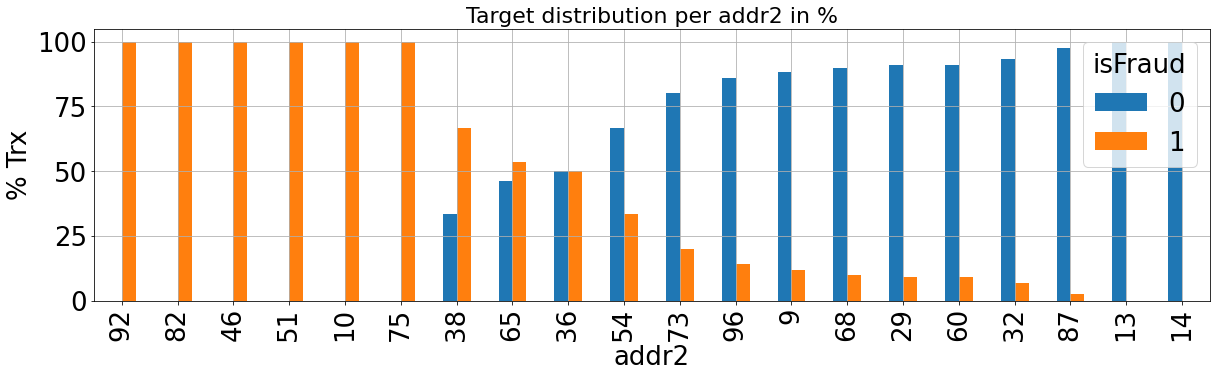


Target distribution per addr2 in Volume:
            count          percent             Total
isFraud         0        1       0       1          
addr2                                               
92            NaN      2.0     NaN  100.00       2.0
82            NaN      1.0     NaN  100.00       1.0
46            NaN      3.0     NaN  100.00       3.0
51            NaN      4.0     NaN  100.00       4.0
10            NaN      8.0     NaN  100.00       8.0
75            NaN      1.0     NaN  100.00       1.0
38            1.0      2.0   33.33   66.67       3.0
65           38.0     44.0   46.34   53.66      82.0
36            1.0      1.0   50.00   50.00       2.0
54            4.0      2.0   66.67   33.33       6.0
73            4.0      1.0   80.00   20.00       5.0
96          549.0     89.0   86.05   13.95     638.0
9         57965.0   7741.0   88.22   11.78   65706.0
68            9.0      1.0   90.00   10.00      10.0
29           10.0      1.0   90.91    9.09      11.0
60  

In [49]:
# addr1 - addr2

addr12 = ['addr1','addr2']
top = 20

for i in range(len(addr12)):
  list_var = [addr12[i], "isFraud"]
  percent_bar_graph(X_train, list_var,top)

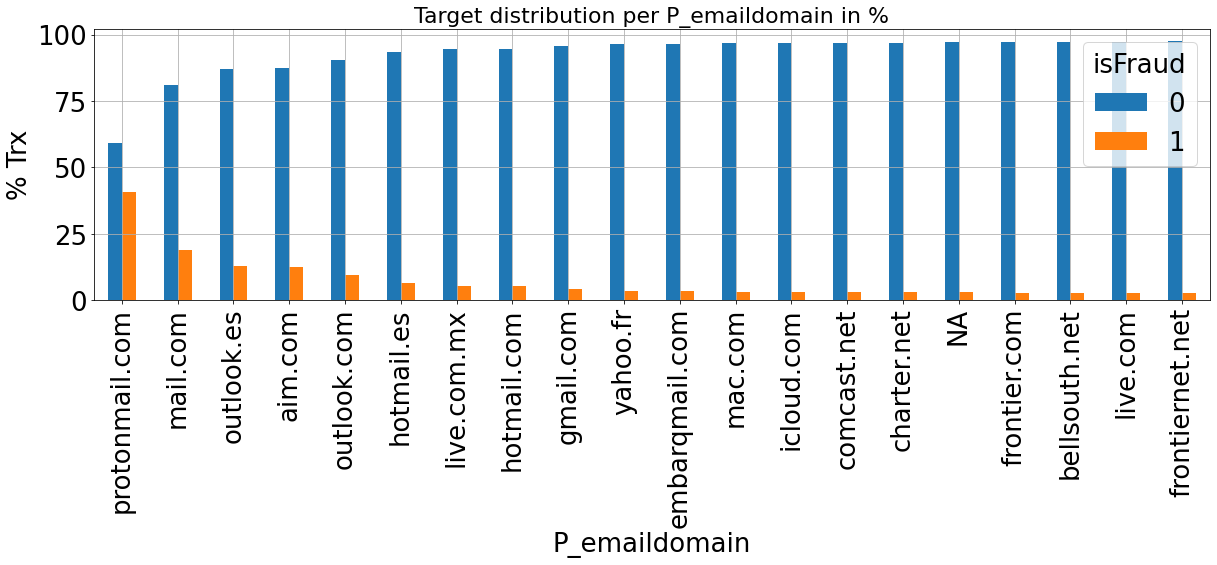


Target distribution per P_emaildomain in Volume:
                    count         percent            Total
isFraud                 0       1       0      1          
P_emaildomain                                             
protonmail.com       45.0    31.0   59.21  40.79      76.0
mail.com            453.0   106.0   81.04  18.96     559.0
outlook.es          381.0    57.0   86.99  13.01     438.0
aim.com             275.0    40.0   87.30  12.70     315.0
outlook.com        4614.0   482.0   90.54   9.46    5096.0
hotmail.es          285.0    20.0   93.44   6.56     305.0
live.com.mx         708.0    41.0   94.53   5.47     749.0
hotmail.com       42854.0  2396.0   94.70   5.30   45250.0
gmail.com        218412.0  9943.0   95.65   4.35  228355.0
yahoo.fr            138.0     5.0   96.50   3.50     143.0
embarqmail.com      251.0     9.0   96.54   3.46     260.0
mac.com             422.0    14.0   96.79   3.21     436.0
icloud.com         6070.0   197.0   96.86   3.14    6267.0
comcas

In [50]:
# P_emaildomain and R_emaildomain

email_domain = ['P_emaildomain']
top = 20

for i in range(len(email_domain)):
  list_var = [email_domain[i], "isFraud"]
  percent_bar_graph(X_train, list_var,top)

### Variables continuas (comentado)

**Matrices de correlación**

  A pesar de ser datos enmascarados, podemos implementar una matriz de correlación que nos ayude a visualizar la influencia de variables sobre otras en el dataset.

Dada la dimensionalidad del dataset exploraremos por grupos estas matrices

In [51]:
# Find only numeric columns
"""
numeric_columns = ['uint8','uint16','int16', 'int32','uint32', 'int64', 'float16', 'float32', 'float64']
X_train_numeric = X_train.select_dtypes(include=numeric_columns)
X_test_numeric = X_test.select_dtypes(include=numeric_columns)

print(X_train_numeric.columns)
print()
print(X_test_numeric.columns)
"""

"\nnumeric_columns = ['uint8','uint16','int16', 'int32','uint32', 'int64', 'float16', 'float32', 'float64']\nX_train_numeric = X_train.select_dtypes(include=numeric_columns)\nX_test_numeric = X_test.select_dtypes(include=numeric_columns)\n\nprint(X_train_numeric.columns)\nprint()\nprint(X_test_numeric.columns)\n"

time: 5.38 ms (started: 2021-06-07 23:58:13 +00:00)


In [52]:
# Grupo D Train
"""
plt.rcParams.update({'font.size': 14})

corr_matrix_D_train = X_train_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']].corr()

fig, ax = plt.subplots(figsize=(15,10))
sn.heatmap(corr_matrix_D_train, annot=True, ax=ax)
plt.show()
"""

"\nplt.rcParams.update({'font.size': 14})\n\ncorr_matrix_D_train = X_train_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']].corr()\n\nfig, ax = plt.subplots(figsize=(15,10))\nsn.heatmap(corr_matrix_D_train, annot=True, ax=ax)\nplt.show()\n"

time: 6.95 ms (started: 2021-06-07 23:58:13 +00:00)


In [53]:
# Grupo D Test
"""
plt.rcParams.update({'font.size': 14})

corr_matrix_D_test = X_test_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']].corr()

fig, ax = plt.subplots(figsize=(15,10))
sn.heatmap(corr_matrix_D_test, annot=True, ax=ax)
plt.show()
"""

"\nplt.rcParams.update({'font.size': 14})\n\ncorr_matrix_D_test = X_test_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']].corr()\n\nfig, ax = plt.subplots(figsize=(15,10))\nsn.heatmap(corr_matrix_D_test, annot=True, ax=ax)\nplt.show()\n"

time: 18.4 ms (started: 2021-06-07 23:58:13 +00:00)


A partir de este grupo podemos obtener algunos coeficientes estadisticos que permitan determinar la relación entre variables y así aplicar una reducción de dimensionalidad inicial:

In [54]:
"""
for i in X_train_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']]:
  print("Column name: {}".format(i))
  print("min value: {}    max_value: {}".format(X_train_numeric[i].min(), X_train_numeric[i].max()))
"""

'\nfor i in X_train_numeric[[\'D1\',\'D2\',\'D3\',\'D4\',\'D6\',\'D8\',\'D9\',\'D11\',\'D12\',\'D14\',\'D15\']]:\n  print("Column name: {}".format(i))\n  print("min value: {}    max_value: {}".format(X_train_numeric[i].min(), X_train_numeric[i].max()))\n'

time: 7.73 ms (started: 2021-06-07 23:58:13 +00:00)


In [55]:
"""
for i in X_test_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']]:
  print("Column name: {}".format(i))
  print("min value: {}    max_value: {}".format(X_test_numeric[i].min(), X_test_numeric[i].max()))
"""

'\nfor i in X_test_numeric[[\'D1\',\'D2\',\'D3\',\'D4\',\'D6\',\'D8\',\'D9\',\'D11\',\'D12\',\'D14\',\'D15\']]:\n  print("Column name: {}".format(i))\n  print("min value: {}    max_value: {}".format(X_test_numeric[i].min(), X_test_numeric[i].max()))\n'

time: 10 ms (started: 2021-06-07 23:58:13 +00:00)


Dado que tenemos escalas distintas para algunas variables, se recomienda normalizarlas primero para aplicar los estadisticos

In [56]:
"""
scaler = MinMaxScaler(copy=True, feature_range=(0,1))

X_train_num_d = X_train_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']]

X_train_d_scale = scaler.fit_transform(X_train_num_d)
"""

"\nscaler = MinMaxScaler(copy=True, feature_range=(0,1))\n\nX_train_num_d = X_train_numeric[['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']]\n\nX_train_d_scale = scaler.fit_transform(X_train_num_d)\n"

time: 7.84 ms (started: 2021-06-07 23:58:13 +00:00)


* Matriz de correlación de Pearson: Asumiendo que las variables poseen una distribución normal

In [57]:
"""
labels = ['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']

corr_matrix_D_n = pd.DataFrame(X_train_d_scale, columns = labels).corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,10))
sn.heatmap(corr_matrix_D_n, annot=True, ax=ax)
plt.show()
"""

"\nlabels = ['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']\n\ncorr_matrix_D_n = pd.DataFrame(X_train_d_scale, columns = labels).corr(method='pearson')\n\nfig, ax = plt.subplots(figsize=(15,10))\nsn.heatmap(corr_matrix_D_n, annot=True, ax=ax)\nplt.show()\n"

time: 8.58 ms (started: 2021-06-07 23:58:13 +00:00)


* Matriz de correlación de Spearman: si no se tiene conocimiento de las distribuciones y se quiere determinar una relación de crecimiento o reducción entre ellas. Para este caso usaremos este enfoque para depurar algunas variables cuya correlación sea superior a -0.5 y +0.5

In [58]:
"""
labels = ['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']

corr_matrix_D_n = pd.DataFrame(X_train_d_scale, columns = labels).corr(method='spearman')

fig, ax = plt.subplots(figsize=(15,10))
sn.heatmap(corr_matrix_D_n, annot=True, ax=ax)
plt.show()
"""

"\nlabels = ['D1','D2','D3','D4','D6','D8','D9','D11','D12','D14','D15']\n\ncorr_matrix_D_n = pd.DataFrame(X_train_d_scale, columns = labels).corr(method='spearman')\n\nfig, ax = plt.subplots(figsize=(15,10))\nsn.heatmap(corr_matrix_D_n, annot=True, ax=ax)\nplt.show()\n"

time: 8.13 ms (started: 2021-06-07 23:58:13 +00:00)


In [59]:
"""
print("Correlación de Spearman:\n")
X_train_d_scale_df = pd.DataFrame(X_train_d_scale, columns = labels)
spearman_var_corr = pd.DataFrame(X_train_d_scale_df.corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates()).reset_index()
spearman_var_corr.head(10)
"""

'\nprint("Correlación de Spearman:\n")\nX_train_d_scale_df = pd.DataFrame(X_train_d_scale, columns = labels)\nspearman_var_corr = pd.DataFrame(X_train_d_scale_df.corr(method=\'spearman\').unstack().sort_values(ascending=False).drop_duplicates()).reset_index()\nspearman_var_corr.head(10)\n'

time: 6.89 ms (started: 2021-06-07 23:58:13 +00:00)


Bajo este enfoque, las tuplas (D8,D9), (D6,D12), (D6,D14), (D12,D14), (D4,D15) poseen una alta correlación, por lo cual 1 de cada tupla es candidata a depurarse del dataset.

In [60]:
# Se eliminan las columnas del dataset grupo D con una alta correlación
"""
corr_columns = spearman_var_corr['level_0'][spearman_var_corr[0] > 0.5].unique()

X_train.drop(corr_columns, axis=1, inplace=True)
X_test.drop(corr_columns, axis=1, inplace=True)
"""

"\ncorr_columns = spearman_var_corr['level_0'][spearman_var_corr[0] > 0.5].unique()\n\nX_train.drop(corr_columns, axis=1, inplace=True)\nX_test.drop(corr_columns, axis=1, inplace=True)\n"

time: 7.43 ms (started: 2021-06-07 23:58:13 +00:00)


In [61]:
X_train.shape, X_test.shape

((590540, 384), (506691, 383))

time: 7.18 ms (started: 2021-06-07 23:58:13 +00:00)


Vamos con el grupo de variables de C1 - C14

In [62]:
"""
c_num_columns = X_train_numeric.columns[12:26]

X_train_num_c = X_train_numeric[c_num_columns]

X_train_c_scale = scaler.fit_transform(X_train_num_c)

corr_matrix_C_n = pd.DataFrame(X_train_c_scale, columns = c_num_columns).corr(method='spearman')

fig, ax = plt.subplots(figsize=(15,10))
sn.heatmap(corr_matrix_C_n, annot=True, ax=ax)
plt.show()
"""

"\nc_num_columns = X_train_numeric.columns[12:26]\n\nX_train_num_c = X_train_numeric[c_num_columns]\n\nX_train_c_scale = scaler.fit_transform(X_train_num_c)\n\ncorr_matrix_C_n = pd.DataFrame(X_train_c_scale, columns = c_num_columns).corr(method='spearman')\n\nfig, ax = plt.subplots(figsize=(15,10))\nsn.heatmap(corr_matrix_C_n, annot=True, ax=ax)\nplt.show()\n"

time: 8.27 ms (started: 2021-06-07 23:58:13 +00:00)


Se eliminan las columnas del dataset grupo C con una alta correlación

In [63]:
"""
X_train_c_scale_df = pd.DataFrame(X_train_c_scale, columns = c_num_columns)
spearman_var_c_corr = pd.DataFrame(X_train_c_scale_df.corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates()).reset_index()

corr_c_columns = spearman_var_c_corr['level_0'][spearman_var_c_corr[0] > 0.5].unique()

X_train.drop(corr_c_columns, axis=1, inplace=True)
X_test.drop(corr_c_columns, axis=1, inplace=True)

X_train.shape, X_test.shape
"""

"\nX_train_c_scale_df = pd.DataFrame(X_train_c_scale, columns = c_num_columns)\nspearman_var_c_corr = pd.DataFrame(X_train_c_scale_df.corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates()).reset_index()\n\ncorr_c_columns = spearman_var_c_corr['level_0'][spearman_var_c_corr[0] > 0.5].unique()\n\nX_train.drop(corr_c_columns, axis=1, inplace=True)\nX_test.drop(corr_c_columns, axis=1, inplace=True)\n\nX_train.shape, X_test.shape\n"

time: 8.58 ms (started: 2021-06-07 23:58:13 +00:00)


In [64]:
#np.array(X_train_numeric.columns[41:])

time: 1.34 ms (started: 2021-06-07 23:58:13 +00:00)




Lo mismo para el grupo V:

In [65]:
"""
import tensorflow as tf
import timeit

nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))
"""

"\nimport tensorflow as tf\nimport timeit\n\nnombre_gpu = tf.test.gpu_device_name()\nif nombre_gpu != '/device:GPU:0':\n  raise SystemError('GPU no encontrada')\nprint('GPU encontrada: {}'.format(nombre_gpu))\n"

time: 6.35 ms (started: 2021-06-07 23:58:13 +00:00)


In [66]:
"""
X_train_v_labels = X_train_numeric.columns[41:]

X_train_num_v = X_train_numeric[X_train_v_labels]   # Grupo V sin escalar

X_train_v_scale = scaler.fit_transform(X_train_num_v)   # Grupo V escalado

print("Correlación de Spearman:\n")
X_train_v_scale_df = pd.DataFrame(X_train_v_scale, columns = X_train_v_labels)


def depuracion_gpu():
  with tf.device('/device:GPU:0'):
    spearman_var_corr_v = pd.DataFrame(X_train_v_scale_df.corr(method='spearman').unstack().sort_values(ascending=False).drop_duplicates()).reset_index()
  
  return spearman_var_corr_v

#gpu_time = timeit.timeit('depuracion_gpu()', number=1, setup='from __main__ import depuracion_gpu')

#print('Tiempo de depuracion: ' + str(gpu_time) + ' segundos')

spearman_var_corr_v = pd.DataFrame(X_train_v_scale_df.corr(method='spearman').unstack().drop_duplicates()).reset_index()
#spearman_var_corr_v = depuracion_gpu()
"""

'\nX_train_v_labels = X_train_numeric.columns[41:]\n\nX_train_num_v = X_train_numeric[X_train_v_labels]   # Grupo V sin escalar\n\nX_train_v_scale = scaler.fit_transform(X_train_num_v)   # Grupo V escalado\n\nprint("Correlación de Spearman:\n")\nX_train_v_scale_df = pd.DataFrame(X_train_v_scale, columns = X_train_v_labels)\n\n\ndef depuracion_gpu():\n  with tf.device(\'/device:GPU:0\'):\n    spearman_var_corr_v = pd.DataFrame(X_train_v_scale_df.corr(method=\'spearman\').unstack().sort_values(ascending=False).drop_duplicates()).reset_index()\n  \n  return spearman_var_corr_v\n\n#gpu_time = timeit.timeit(\'depuracion_gpu()\', number=1, setup=\'from __main__ import depuracion_gpu\')\n\n#print(\'Tiempo de depuracion: \' + str(gpu_time) + \' segundos\')\n\nspearman_var_corr_v = pd.DataFrame(X_train_v_scale_df.corr(method=\'spearman\').unstack().drop_duplicates()).reset_index()\n#spearman_var_corr_v = depuracion_gpu()\n'

time: 12.2 ms (started: 2021-06-07 23:58:13 +00:00)


In [67]:
  #spearman_var_corr_v.head()

time: 1.27 ms (started: 2021-06-07 23:58:13 +00:00)


En este caso, para no perder tanta informacion establecemos un umbral de más del 70% de varianza como limite para la depuración

In [68]:
#spearman_var_corr_v['level_0'].unique().shape

time: 1.23 ms (started: 2021-06-07 23:58:13 +00:00)


In [69]:
"""
corr_columns_v = spearman_var_corr_v['level_0'][spearman_var_corr_v[0] > 0.5].unique()  
corr_columns_v.shape
"""

"\ncorr_columns_v = spearman_var_corr_v['level_0'][spearman_var_corr_v[0] > 0.5].unique()  \ncorr_columns_v.shape\n"

time: 7.36 ms (started: 2021-06-07 23:58:13 +00:00)


In [70]:
"""
corr_columns_v = spearman_var_corr_v['level_0'][spearman_var_corr_v[0] > 0.5].unique()    

# Se eliminan las columnas del dataset grupo V con una alta correlación

X_train.drop(corr_columns_v, axis=1, inplace=True)
X_test.drop(corr_columns_v, axis=1, inplace=True)
"""

"\ncorr_columns_v = spearman_var_corr_v['level_0'][spearman_var_corr_v[0] > 0.5].unique()    \n\n# Se eliminan las columnas del dataset grupo V con una alta correlación\n\nX_train.drop(corr_columns_v, axis=1, inplace=True)\nX_test.drop(corr_columns_v, axis=1, inplace=True)\n"

time: 5.87 ms (started: 2021-06-07 23:58:13 +00:00)


In [71]:
X_train.shape, X_test.shape

((590540, 384), (506691, 383))

time: 7.43 ms (started: 2021-06-07 23:58:13 +00:00)


* **Removiendo variables con poca varianza:** Para comparar métodos de depuración de variables, se buscará cuales no brindan información acerca de las dinámicas de los datos, por ende se puede declarar un umbral de varianza aceptable para conservar los datos que sí posean dinámicas.

In [72]:
# Normalizacion con Normalizer
"""
from sklearn.preprocessing import Normalizer

norm = Normalizer()

X_train_v_norm = norm.fit_transform(X_train_num_v)   # Grupo V escalado

df_X_train_v_scale = pd.DataFrame(X_train_v_norm, columns = X_train_v_labels)
"""

'\nfrom sklearn.preprocessing import Normalizer\n\nnorm = Normalizer()\n\nX_train_v_norm = norm.fit_transform(X_train_num_v)   # Grupo V escalado\n\ndf_X_train_v_scale = pd.DataFrame(X_train_v_norm, columns = X_train_v_labels)\n'

time: 8.16 ms (started: 2021-06-07 23:58:13 +00:00)


In [73]:
# Implementacion de Low Variance 
"""
from sklearn.feature_selection import VarianceThreshold

threshold_n=0.95

sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
sel_var=sel.fit_transform(df_X_train_v_scale)

df_X_train_v_scale[df_X_train_v_scale.columns[sel.get_support(indices=True)]] 

df_X_train_v_scale.shape
"""

'\nfrom sklearn.feature_selection import VarianceThreshold\n\nthreshold_n=0.95\n\nsel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))\nsel_var=sel.fit_transform(df_X_train_v_scale)\n\ndf_X_train_v_scale[df_X_train_v_scale.columns[sel.get_support(indices=True)]] \n\ndf_X_train_v_scale.shape\n'

time: 9.12 ms (started: 2021-06-07 23:58:13 +00:00)


Con un umbral de 5% de varianza entre los datos, vemos que todos superan el umbral y por ende presentan una varianza superior, por ende con este método no eliminamos variables, continuamos con la depuración realizada a partir del análisis de Correlación

### Preprocesamiento

Ahora además de limpiar valores perdidos e implementar análisis de correlación, procederemos a estrategias de imputación de variables, escalamiento y reducción de dimensionalidad que permitan tener un mejor manejo de los datos.

* Anteriormente se limpió el dataset completo (incluyendo train y test), en este caso preprocesaremos unicamente train, dado que el test lo dejaremos para la prueba de rendimiento del modelo

In [74]:
df = X_train

# Marcamos por separado la data de test
df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

time: 33 ms (started: 2021-06-07 23:58:13 +00:00)


In [75]:
# limpiamos los dataset anteriores

#del X_train; x = gc.collect()

time: 1.59 ms (started: 2021-06-07 23:58:13 +00:00)


In [76]:
# Ya contamos con el dataset Limpio para trabajar dada la depuración inicial
df.isnull().values.any()

False

time: 382 ms (started: 2021-06-07 23:58:13 +00:00)


* Dada la alta dimensionalidad del modelo, podemos plantear una estrategia de PCA para reducir la dimensionalidad del total de features.

###Transformación de variables categóricas

Mediante una estrategia de One Hot Encoding para unificar la jerarquía entre las observaciones

In [77]:
# Selecciono las variables categoricas
variables_categoricas = df.drop('isFraud', axis = 1).select_dtypes(include = "object").columns
print(variables_categoricas)

data_cat = pd.get_dummies(df[variables_categoricas])
data_other_cols = df.drop(columns=variables_categoricas)

df_out = pd.concat([data_other_cols,data_cat],axis=1)

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain'], dtype='object')
time: 1.09 s (started: 2021-06-07 23:58:14 +00:00)


In [78]:
df_out.shape

(590540, 455)

time: 4.48 ms (started: 2021-06-07 23:58:15 +00:00)


### Particionamiento de datos y Escalamiento

Por medio de un standardScaler (media 0, varianza 1) para todas las variables. Se hace necesario dado que existen diferentes tipos de variables en el dataset, provenientes tanto de variables categóricas como numéricas.

Así mismo el escalammiento es necesario para aplicar reducción de dimensionalidad con métodos relacionados con la Varianza, como es el caso de PCA.

In [79]:
X = df_out
#X = df
X_val = X_test # nomenclamos diferente porque posteriormente particionaremos un test nuevo para validar el modelo

time: 1.88 ms (started: 2021-06-07 23:58:15 +00:00)


En este dataset solo X posee el target, X_val tiene datos nuevos que son los que mediremos la efectividad real del modelo, entonces para el entrenamiento y validación usaremos solo X y lo particionaremos:

In [80]:
y = X['isFraud']
X = X.drop('isFraud', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y, random_state = 123)

time: 3.35 s (started: 2021-06-07 23:58:15 +00:00)


Usando una estrategia de escalamiento en la que los Outliers tengan una incidencia menor respecto a los métodos de StandardScaler o MinMaxScaler.

In [81]:
scaler = RobustScaler(copy=True)
#scaler = MinMaxScaler(copy=True, feature_range=(0,1))

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)

time: 8.87 s (started: 2021-06-07 23:58:18 +00:00)


In [82]:
X_train_n.shape, X_test_n.shape

((472432, 454), (118108, 454))

time: 4.55 ms (started: 2021-06-07 23:58:27 +00:00)


###Reducción de Dimensionalidad

Aplicando un Análisis de Componentes principales a los datos depurados. Primero reviso a partir de una exploración de Varianza acumulada cuantos componentes principales me brindan la mayor cantidad de información de los datos.

Para esto aplicamos el análisis de componentes para todas las variables, en las que cada una queda con un peso determinado, posteriormente aplicamos la suma acumulada de varianzas para determinar el número óptimo de componentes según el umbral de varianza acumulada a conservar.

In [83]:
# limpiamos los dataset anteriores

#del X_train,X_test; x = gc.collect()

time: 1.23 ms (started: 2021-06-07 23:58:27 +00:00)


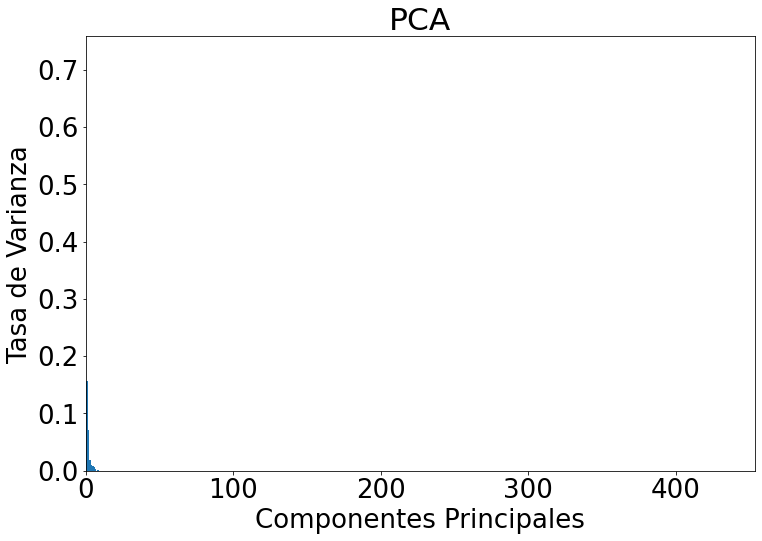

<Figure size 432x288 with 0 Axes>

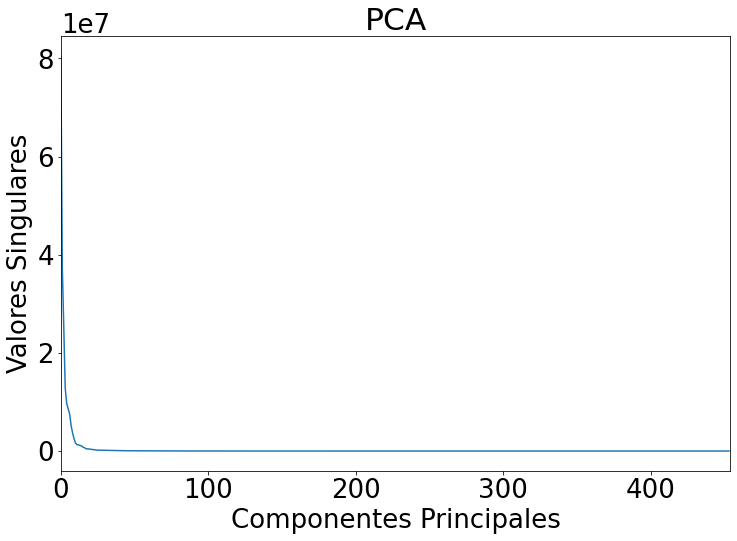

time: 55.6 s (started: 2021-06-07 23:58:27 +00:00)


In [84]:
pca = PCA(
          n_components = X_train_n.shape[1], 
          random_state = 42, 
          svd_solver='auto', 
          tol = 1e-3, 
          whiten = False
          )
Variables_Principales = pca.fit_transform(X_train_n) 

Varianza = pca.explained_variance_ratio_ # Calculamos la tasa de varianza de las componentes y generamos las componentes principales
Valores_Singulares = pca.singular_values_

fig = plt.figure(figsize=(12,8))
plt.bar(np.arange(len(Varianza)), Varianza)
plt.xlabel('Componentes Principales')
plt.ylabel('Tasa de Varianza')
plt.title('PCA')
plt.xlim(0, len(Varianza))
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
plt.plot(np.arange(len(Valores_Singulares)), Valores_Singulares)
plt.xlabel('Componentes Principales')
plt.ylabel('Valores Singulares')
plt.title('PCA')
plt.xlim(0, len(Valores_Singulares))
plt.show()

Importancia_Componentes = pd.DataFrame(data = Varianza)
Importancia_Componentes = Importancia_Componentes.T

In [85]:
print("Porcentaje de Varianza detectada para las primeras 5 componentes: ", format(100*Importancia_Componentes.loc[:,0:5].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 10 componentes: ", format(100*Importancia_Componentes.loc[:,0:9].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 20 componentes: ", format(100*Importancia_Componentes.loc[:,0:19].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 30 componentes: ", format(100*Importancia_Componentes.loc[:,0:29].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 40 componentes: ", format(100*Importancia_Componentes.loc[:,0:39].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 50 componentes: ", format(100*Importancia_Componentes.loc[:,0:49].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 60 componentes: ", format(100*Importancia_Componentes.loc[:,0:59].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 70 componentes: ", format(100*Importancia_Componentes.loc[:,0:69].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 80 componentes: ", format(100*Importancia_Componentes.loc[:,0:79].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 90 componentes: ", format(100*Importancia_Componentes.loc[:,0:89].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 100 componentes: ", format(100*Importancia_Componentes.loc[:,0:99].sum(axis = 1).values))
print("Porcentaje de Varianza detectada para las primeras 110 componentes: ", format(100*Importancia_Componentes.loc[:,0:108].sum(axis = 1).values))

Porcentaje de Varianza detectada para las primeras 5 componentes:  [98.73768359]
Porcentaje de Varianza detectada para las primeras 10 componentes:  [99.88103947]
Porcentaje de Varianza detectada para las primeras 20 componentes:  [99.99132467]
Porcentaje de Varianza detectada para las primeras 30 componentes:  [99.99784061]
Porcentaje de Varianza detectada para las primeras 40 componentes:  [99.99929117]
Porcentaje de Varianza detectada para las primeras 50 componentes:  [99.99972634]
Porcentaje de Varianza detectada para las primeras 60 componentes:  [99.99989439]
Porcentaje de Varianza detectada para las primeras 70 componentes:  [99.99996306]
Porcentaje de Varianza detectada para las primeras 80 componentes:  [99.99999117]
Porcentaje de Varianza detectada para las primeras 90 componentes:  [99.99999796]
Porcentaje de Varianza detectada para las primeras 100 componentes:  [99.99999935]
Porcentaje de Varianza detectada para las primeras 110 componentes:  [99.99999968]
time: 45.5 ms (

Con este análisis de varianza acumulada, con 70 a 80 componentes tenemos más del 99.9% de la información relevante en los datos, pasando de una dimensión de 109 features (dado por el OHE) a 70 componentes principales seleccionados para el entrenamiento.

In [100]:
# Creo una función para ejecutar el PCA

def dim_reduction(X_train, X_test, v_features, n_components):
    
    pca = PCA(n_components = n_components, random_state = 123)
    len_v_features = np.array(v_features).shape[1]
    len_X = X_train.shape[1]
    len_dif = len_X-len_v_features

    pca.fit(X_train[:,len_dif:])

    X_train_pca = pca.transform(X_train[:,len_dif:])
    X_train_wout_pca = X_train[:,:len_dif]
    X_train = np.concatenate([X_train_wout_pca, X_train_pca], axis=1)

    X_test_pca = pca.transform(X_test[:,len_dif:])
    X_test_wout_pca = X_test[:,:len_dif]
    X_test = np.concatenate([X_test_wout_pca, X_test_pca], axis=1)
    
    return X_train, X_test, pca

time: 18.1 ms (started: 2021-06-08 00:09:03 +00:00)


In [102]:
num_pca_components = 70

v_data = X_train_n
X_train_r, X_test_r, pca_model = dim_reduction(X_train = X_train_n, X_test = X_test_n, v_features = v_data, n_components = num_pca_components)
X_train_r.shape, X_test_r.shape

((472432, 70), (118108, 70))

time: 21.2 s (started: 2021-06-08 00:09:34 +00:00)


Dado que aumentó el consumo de memoria debido a las transformaciones, reducimos el tamaño de los features de nuevo

In [88]:
X_train_r.dtype, X_train_n.dtype, X_test_r.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

time: 12.5 ms (started: 2021-06-08 00:00:05 +00:00)


In [89]:
if X_train_n.dtype=='float64': X_train_n = X_train_n.astype('float32')
if X_train_r.dtype=='float64': X_train_r = X_train_r.astype('float32')
if X_test_n.dtype=='float64': X_test_n = X_test_n.astype('float32') 
if X_test_r.dtype=='float64': X_test_r = X_test_r.astype('float32')

time: 677 ms (started: 2021-06-08 00:00:05 +00:00)


In [90]:
X_train_r.dtype, X_train_n.dtype, X_test_r.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

time: 8.87 ms (started: 2021-06-08 00:00:05 +00:00)


In [91]:
# Depuro el X_train y X_test original
#del X_train, X_test; x= gc.collect()

time: 1.58 ms (started: 2021-06-08 00:00:05 +00:00)


## Modelos ML

**Nota:** Para la entrega los modelos expuestos a continuación ya pasaron por una etapa de entrenamiento y sintonización de hiperparámetros, serializando los serializando los mejores estimadores en formato **.pkl**.

Dado lo anterior los entrenamientos aparecerán comentados para evitar su ejecución.

## Baseline - Logistic Regression

Iniciando con un modelo de referencia para comparar métricas respecto a modelos más complejos

In [91]:
y_train = np.array(y_train.astype('int'))

"""
# Grid de hiperparámetros evaluados
param_grid = {#"C"            : [0.001,0.01,0.1,1,10], 
              "penalty"      : ["l2"],
              "solver"       : ["saga"],
              #"class_weight" : ["balanced",{0:0.1, 1:0.9}]
              "class_weight" : ["balanced"]
              }

st = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=0)

# Búsqueda por grid search con validación cruzada
lr_grid = GridSearchCV(
        estimator  = LogisticRegression(random_state = 42),
        param_grid = param_grid,
        #scoring    = scoring,
        scoring    = 'balanced_accuracy',
        cv         = st, 
        #refit      = 'balanced_accuracy_score',
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )
"""

'\n# Grid de hiperparámetros evaluados\nparam_grid = {#"C"            : [0.001,0.01,0.1,1,10], \n              "penalty"      : ["l2"],\n              "solver"       : ["saga"],\n              #"class_weight" : ["balanced",{0:0.1, 1:0.9}]\n              "class_weight" : ["balanced"]\n              }\n\nst = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=0)\n\n# Búsqueda por grid search con validación cruzada\nlr_grid = GridSearchCV(\n        estimator  = LogisticRegression(random_state = 42),\n        param_grid = param_grid,\n        #scoring    = scoring,\n        scoring    = \'balanced_accuracy\',\n        cv         = st, \n        #refit      = \'balanced_accuracy_score\',\n        refit      = True,\n        verbose    = 0,\n        return_train_score = True\n       )\n'

time: 18.7 ms (started: 2021-06-07 23:26:38 +00:00)


In [ ]:
# Entrenamiento
#y_train = np.array(y_train.astype('int'))
#lr_grid.fit(X = X_train_r, y = y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced'], 'penalty': ['l2'],
                         'solver': ['saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='balanced_accuracy', verbose=0)

time: 6min 2s (started: 2021-05-28 04:47:53 +00:00)


In [ ]:
# Resultados
"""
lr_results = pd.DataFrame(lr_grid.cv_results_)
lr_results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)
"""

,param_class_weight,param_penalty,param_solver,mean_test_score,std_test_score,mean_train_score,std_train_score
0,balanced,l2,saga,0.651667,0.06129,0.651456,0.063117


time: 25 ms (started: 2021-05-28 04:55:01 +00:00)


In [ ]:
# Mejores hiperparámetros por validación cruzada
"""
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(lr_grid.best_params_, ":", lr_grid.best_score_, lr_grid.scoring)
"""

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} : 0.6516666672969654 balanced_accuracy
time: 3.08 ms (started: 2021-05-28 04:55:10 +00:00)


In [ ]:
# Modelo con mejor rendimiento
#lr_cl = lr_grid.best_estimator_

time: 890 µs (started: 2021-05-28 04:55:12 +00:00)


In [ ]:
"""
# save the model to disk
lr_model_saved = 'lr_model.sav'
pickle.dump(lr_cl, open(lr_model_saved, 'wb'))
"""

time: 13.7 ms (started: 2021-05-26 00:48:11 +00:00)


In [ ]:
"""
from google.colab import files

files.download('lr_model.sav')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 8.78 ms (started: 2021-05-26 00:48:31 +00:00)


In [92]:
# load the model from disk
files.upload()

filename = 'lr_model.sav'

lr_cl = pickle.load(open(filename, 'rb'))
lr_cl_score = lr_cl.score(X_test_r, y_test)
print(lr_cl_score)

Saving lr_model.sav to lr_model.sav
0.7427947302468927
time: 7.98 s (started: 2021-06-07 23:26:43 +00:00)


Text(0.5, 1.0, 'CM Logistic Regression Classifier')

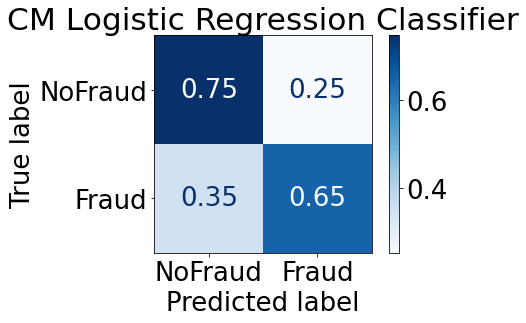

time: 429 ms (started: 2021-06-07 23:26:54 +00:00)


In [93]:
y_test = np.array(y_test.astype('int'))

# Busqueda por accuracy
disp = plot_confusion_matrix(lr_cl, X_test_r, y_test,
                                 display_labels=['NoFraud','Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
disp.ax_.set_title('CM Logistic Regression Classifier')

In [94]:
print('Accuracy test= '+str(accuracy_score(y_test,lr_cl.predict(X_test_r))))
print('Balanced Accuracy test = '+str(balanced_accuracy_score(y_test,lr_cl.predict(X_test_r))))

Accuracy test= 0.7427947302468927
Balanced Accuracy test = 0.697327832886211
time: 203 ms (started: 2021-06-07 23:26:58 +00:00)


**Métricas de desempeño**

In [110]:
lr_y_pred = lr_cl.predict(X_test_r)

pr_lr_score = precision_score(y_test,lr_y_pred, average='macro')
print('Precision test = '+str(pr_lr_score))

recall_lr_score = recall_score(y_test,lr_y_pred, average='macro')
print('Recall test = '+str(recall_lr_score))

f1_lr_score = f1_score(y_test,lr_y_pred, average='macro')
print('F1 test = '+str(f1_lr_score))

mcc_lr_score = matthews_corrcoef(y_test,lr_y_pred)
print('MCC test = '+str(mcc_lr_score))

auc_lr_score = roc_auc_score(y_test,lr_y_pred)
print('ROC AUC test = '+str(auc_lr_score))

Precision test = 0.5339998020393604
Recall test = 0.697327832886211
F1 test = 0.4992262822817706
MCC test = 0.16381828048160144
ROC AUC test = 0.697327832886211
time: 344 ms (started: 2021-06-07 23:32:57 +00:00)


## Modelo - Random Forest Classifier

Por medio de un GridSearch entrenamos un clasificador con el algoritmo de Bosques Aleatorios, sintonizando hiperparámetros como # de estimadores (árboles) y la profundidad (hojas) de cada árbol


In [ ]:
"""
y_train = np.array(y_train.astype('int'))

# Grid de hiperparámetros evaluados
param_grid = {'n_estimators': [50],
              'max_features': [10],
              'max_depth'   : [10],
              'class_weight': ['balanced_subsample']
             }

st = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=0)

# Búsqueda por grid search con validación cruzada
rf_grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'balanced_accuracy',
        #n_jobs     = multiprocessing.cpu_count()-1,
        cv         = st, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )
"""

time: 19.3 ms (started: 2021-05-28 04:57:06 +00:00)


In [ ]:
"""
y_train = np.array(y_train.astype('int'))

rf_grid.fit(X = X_train_r, y = y_train)
"""

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_st

time: 27min 15s (started: 2021-05-28 04:57:12 +00:00)


In [ ]:
"""
# Resultados
resultados = pd.DataFrame(rf_grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)
    """

,param_class_weight,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
17,balanced_subsample,10,9,30,0.782729,0.002619,0.818662,0.001270
14,balanced_subsample,10,7,30,0.781763,0.003189,0.816272,0.000741
16,balanced_subsample,10,9,20,0.781710,0.002800,0.818042,0.001059
11,balanced_subsample,10,5,30,0.781167,0.003044,0.812426,0.001049


time: 18.9 ms (started: 2021-05-26 03:09:54 +00:00)


In [ ]:
# Mejores hiperparámetros por validación cruzada
"""
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(rf_grid.best_params_, ":", rf_grid.best_score_, rf_grid.scoring)
"""

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 9, 'n_estimators': 30} : 0.7827294693754887 balanced_accuracy
time: 5.06 ms (started: 2021-05-26 03:10:07 +00:00)


In [ ]:
# Modelo con mejor rendimiento
#rf_cl = rf_grid.best_estimator_

time: 835 µs (started: 2021-05-26 03:10:28 +00:00)


In [96]:
# load the model from disk
files.upload()

filename = 'rf_model.sav'

rf_cl = pickle.load(open(filename, 'rb'))
rf_cl_score = rf_cl.score(X_test_r, y_test)
print(rf_cl_score)

Saving rf_model.sav to rf_model.sav
0.7660023029769364
time: 22.7 s (started: 2021-06-07 23:27:43 +00:00)


In [97]:
print('Accuracy test= '+str(accuracy_score(y_test,rf_cl.predict(X_test_r))))
print('Balanced Accuracy test = '+str(balanced_accuracy_score(y_test,rf_cl.predict(X_test_r))))

Accuracy test= 0.7660023029769364
Balanced Accuracy test = 0.7166976056645173
time: 914 ms (started: 2021-06-07 23:28:11 +00:00)


Desempeño del Modelo

Text(0.5, 1.0, 'CM Random Forest Classifier')

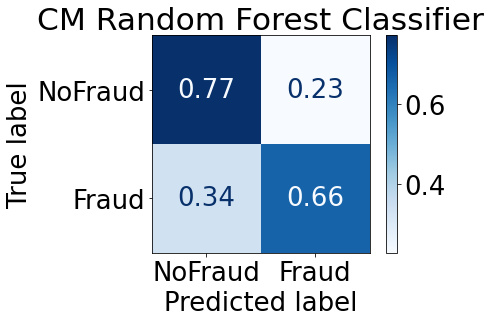

time: 741 ms (started: 2021-06-07 23:28:16 +00:00)


In [98]:
y_test = np.array(y_test.astype('int'))

# Busqueda por accuracy
disp = plot_confusion_matrix(rf_cl, X_test_r, y_test,
                                 display_labels=['NoFraud','Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
disp.ax_.set_title('CM Random Forest Classifier')

In [99]:
print('Accuracy test= '+str(accuracy_score(y_test,rf_cl.predict(X_test_r))))
print('Balanced Accuracy test = '+str(balanced_accuracy_score(y_test,rf_cl.predict(X_test_r))))

Accuracy test= 0.7660023029769364
Balanced Accuracy test = 0.7166976056645173
time: 918 ms (started: 2021-06-07 23:28:21 +00:00)


<Figure size 432x288 with 0 Axes>

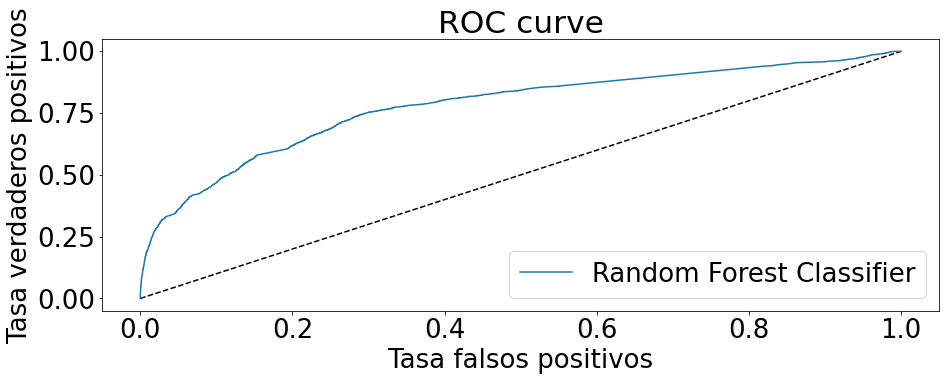

time: 694 ms (started: 2021-06-07 23:28:26 +00:00)


In [100]:
# ROC parameters
y_pred_rf = rf_cl.predict_proba(X_test_r)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# ROC Curve
plt.figure(1)
plt.figure(figsize=(15,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest Classifier')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Métricas de desempeño**

In [111]:
rf_y_pred = rf_cl.predict(X_test_r)

pr_rf_score = precision_score(y_test,rf_y_pred, average='macro')
print('Precision test = '+str(pr_rf_score))

recall_rf_score = recall_score(y_test,rf_y_pred, average='macro')
print('Recall test = '+str(recall_rf_score))

f1_rf_score = f1_score(y_test,rf_y_pred, average='macro')
print('F1 test = '+str(f1_rf_score))

mcc_rf_score = matthews_corrcoef(y_test,rf_y_pred)
print('MCC test = '+str(mcc_rf_score))

auc_rf_score = roc_auc_score(y_test,rf_y_pred)
print('ROC AUC test = '+str(auc_rf_score))

Precision test = 0.5395107680581105
Recall test = 0.7166976056645173
F1 test = 0.5147722897536445
MCC test = 0.18506095035051162
ROC AUC test = 0.7166976056645173
time: 665 ms (started: 2021-06-07 23:33:33 +00:00)


## LightGBM

Se instalan las dependencias externas correspondientes a la librería de Lightgbm.

Documentación: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html


In [112]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
time: 3.6 s (started: 2021-06-07 23:33:40 +00:00)


In [113]:
!pip install lightgbm

time: 3.33 s (started: 2021-06-07 23:33:46 +00:00)


In [114]:
from lightgbm.sklearn import LGBMClassifier
"""
# Grid de hiperparámetros
param_grid = {
    'n_estimators' : [1000],
    'boosting_type' : ['gbdt'],
    #'num_leaves': [64,128],
    'objective': ['binary'],
    'class_weight' : ['balanced'],
    #'min_data_in_leaf': [12],
    'learning_rate': [0.1],
    'feature_fraction': [0.4],
    'bagging_fraction': [0.8],
    #'bagging_freq': [1],
    #'max_cat_to_onehot': [128],
    #'metric': ['auc','binary_logloss'],
    'num_threads': [8],
    'seed': [42],
    #'subsample' : [0.8],
    #'subsample_freq' : 0
}

st = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=0)

# Búsqueda por grid search con validación cruzada
lgbm_cl = GridSearchCV(
        estimator  = LGBMClassifier(random_state=123),
        param_grid = param_grid,
        #n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = st, 
        verbose    = 1
       )

lgbm_cl.fit(X = X_train_r, y = y_train)

# Resultados
resultados = pd.DataFrame(lgbm_cl.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)
"""

"\n# Grid de hiperparámetros\nparam_grid = {\n    'n_estimators' : [1000],\n    'boosting_type' : ['gbdt'],\n    #'num_leaves': [64,128],\n    'objective': ['binary'],\n    'class_weight' : ['balanced'],\n    #'min_data_in_leaf': [12],\n    'learning_rate': [0.1],\n    'feature_fraction': [0.4],\n    'bagging_fraction': [0.8],\n    #'bagging_freq': [1],\n    #'max_cat_to_onehot': [128],\n    #'metric': ['auc','binary_logloss'],\n    'num_threads': [8],\n    'seed': [42],\n    #'subsample' : [0.8],\n    #'subsample_freq' : 0\n}\n\nst = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=0)\n\n# Búsqueda por grid search con validación cruzada\nlgbm_cl = GridSearchCV(\n        estimator  = LGBMClassifier(random_state=123),\n        param_grid = param_grid,\n        #n_jobs     = multiprocessing.cpu_count() - 1,\n        cv         = st, \n        verbose    = 1\n       )\n\nlgbm_cl.fit(X = X_train_r, y = y_train)\n\n# Resultados\nresultados = pd.DataFrame(lgbm_cl.cv_results_)\nr

time: 117 ms (started: 2021-06-07 23:33:53 +00:00)


In [ ]:
# Mejores hiperparámetros por validación cruzada
"""
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(lgbm_cl.best_params_, ":", lgbm_cl.best_score_, lgbm_cl.scoring)
"""

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'class_weight': 'balanced', 'feature_fraction': 0.4, 'learning_rate': 0.1, 'n_estimators': 1000, 'num_threads': 8, 'objective': 'binary', 'seed': 42} : 0.9005281149787802 None
time: 7.74 ms (started: 2021-05-28 05:53:58 +00:00)


In [ ]:
# Clasificador con los parametros de mejor desempeño
#lgbm_cl_best = lgbm_cl.best_estimator_

time: 1.12 ms (started: 2021-05-28 05:54:02 +00:00)


In [ ]:
# save the model to disk
"""
filename = 'lgbm_model.sav'
pickle.dump(lgbm_cl_best, open(filename, 'wb'))

from google.colab import files

files.download('lgbm_model.sav')
"""

In [109]:
# load the model from disk
files.upload()

filename = 'lgbm_model.sav'

lgbm_cl_best = pickle.load(open(filename, 'rb'))
lgbm_cl_score = lgbm_cl_best.score(X_test_r, y_test)
print(lgbm_cl_score)

Saving lgbm_model.sav to lgbm_model (1).sav
0.8854184305889525
time: 26 s (started: 2021-06-08 00:12:57 +00:00)


Text(0.5, 1.0, 'CM primera iteración')

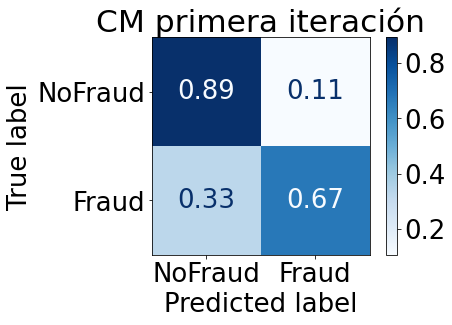

time: 9.43 s (started: 2021-06-08 00:13:29 +00:00)


In [110]:
# Confusion matrix
y_test = np.array(y_test.astype('int'))
y_pred_gb = lgbm_cl_best.predict(X = X_test_r)

# Plot
disp = plot_confusion_matrix(lgbm_cl_best, X_test_r, y_test,
                                 display_labels=['NoFraud','Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
disp.ax_.set_title('CM primera iteración')

In [111]:
print('Accuracy test= '+str(accuracy_score(y_test,lgbm_cl_best.predict(X_test_r))))
print('Balanced Accuracy test = '+str(balanced_accuracy_score(y_test,lgbm_cl_best.predict(X_test_r))))

Accuracy test= 0.8854184305889525
Balanced Accuracy test = 0.7837008086094582
time: 9.34 s (started: 2021-06-08 00:13:42 +00:00)


**Métricas de desempeño**

In [112]:
lgbm_y_pred = lgbm_cl_best.predict(X_test_r)

pr_lgbm_score = precision_score(y_test,lgbm_y_pred, average='macro')
print('Precision test = '+str(pr_lgbm_score))

recall_lgbm_score = recall_score(y_test,lgbm_y_pred, average='macro')
print('Recall test = '+str(recall_lgbm_score))

f1_lgbm_score = f1_score(y_test,lgbm_y_pred, average='macro')
print('F1 test = '+str(f1_lgbm_score))

mcc_lgbm_score = matthews_corrcoef(y_test,lgbm_y_pred)
print('MCC test = '+str(mcc_lgbm_score))

auc_lgbm_score = roc_auc_score(y_test,lgbm_y_pred)
print('ROC AUC test = '+str(auc_lgbm_score))

Precision test = 0.5865358151555365
Recall test = 0.7837008086094582
F1 test = 0.6146964001542528
MCC test = 0.3133705840266716
ROC AUC test = 0.7837008086094582
time: 4.89 s (started: 2021-06-08 00:13:54 +00:00)


##Implementación sobre nuevos datos

Usando el X_val que contiene solo datos nuevos, generamos un dataset resultado con el Id de transacción, las probabilidades de cada clase y la predicción

In [103]:
# Selecciono las variables categoricas
variables_categoricas = X_val.select_dtypes(include = "object").columns
print(variables_categoricas)

data_cat = pd.get_dummies(X_val[variables_categoricas])
data_other_cols = X_val.drop(columns=variables_categoricas)

df_out = pd.concat([data_other_cols,data_cat],axis=1)

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain'], dtype='object')
time: 958 ms (started: 2021-06-08 00:10:10 +00:00)


Preprocesamiento de los nuevos datos

In [122]:
X_Val_n = scaler.transform(df_out)

time: 1.68 s (started: 2021-06-08 00:22:32 +00:00)


Reduccion de dimensionalidad para los nuevos datos

In [123]:
X_val_r = pca_model.transform(X_Val_n)

time: 3.15 s (started: 2021-06-08 00:22:41 +00:00)


In [124]:
# Resultado de la prediccion con los nuevos datos
y_res_predict_probas = lgbm_cl_best.predict_proba(X_val_r)
y_res_predict = lgbm_cl_best.predict(X_val_r)

time: 40.2 s (started: 2021-06-08 00:22:48 +00:00)


In [126]:
df_y_res = pd.DataFrame(y_res_predict, columns = ['isFraud'])
df_y_res.value_counts()

isFraud
0          506671
1              20
dtype: int64

time: 23.7 ms (started: 2021-06-08 00:23:42 +00:00)


In [127]:
# Insertamos sobre X_val original las predicciones
X_val['ProbFraud'] = y_res_predict_probas[:,1]
X_val['ProbNotFraud'] = y_res_predict_probas[:,0]
X_val['isFraud'] = y_res_predict

time: 12.6 ms (started: 2021-06-08 00:23:52 +00:00)


In [128]:
# Generamos el dataset resultado del modelo
pred_model = X_val.loc[:,['TransactionID','ProbFraud','ProbNotFraud','isFraud']]
#pred_model.sample(n = 20) 

time: 13.2 ms (started: 2021-06-08 00:23:54 +00:00)


In [129]:
# Determinamos el volumen del target isFraud para el resultado de la primera iteración

print(pred_model['isFraud'].value_counts())

# En porcentaje
print("\n",(pred_model['isFraud'].value_counts()/pred_model.shape[0])*100)

0    506671
1        20
Name: isFraud, dtype: int64

 0    99.996053
1     0.003947
Name: isFraud, dtype: float64
time: 30 ms (started: 2021-06-08 00:23:57 +00:00)


In [130]:
# Kaggle submission
res_submission = pred_model[['TransactionID','isFraud']]
res_submission.to_csv(r"res_submission.csv")
files.download('res_submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 984 ms (started: 2021-06-08 00:24:24 +00:00)
